# Battery storage example

This is work in progress and models the management of a household-size battery store with random prices.

In [1]:
from pyquasar import *

In [2]:
num_hours = 24
power_loss = 0.8
storage_capacity = 100
power_capacity = 25
initial_storage  = 0

model = DecisionProblem()
for t in range(num_hours):
    final_storage, charge, discharge = model.add_variables(t, "storage", "charge", "discharge")
    
    #storage balance over time
    model += final_storage == initial_storage + power_loss*charge - discharge

    #storage limits
    model += final_storage <= storage_capacity
    model += charge <= power_capacity
    model += discharge <= power_capacity
    
    #objective function
    model += rand("price") * (discharge - charge)
    
    #assign storage to previous_storage for next loop
    initial_storage = final_storage

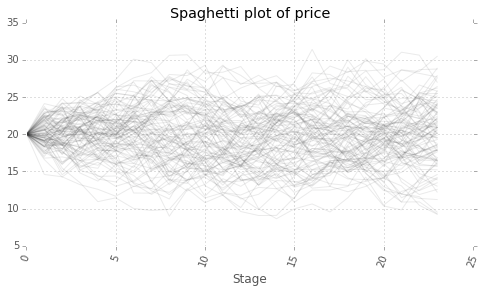

In [3]:
name ="price"; mu=2;  sigma=2;  phi=[0.9];  initial_price=[20]
price_process = ARModel(name,
                  constant=mu, 
                  sigma=sigma, 
                  ar_coefficients=phi, 
                  initial_state=initial_price)
sample = price_process.simulate(num_stages=num_hours, sample_size=100)
sample.price.spaghetti()

In [4]:
opt = DynamicOptimizer(model, price_process)
opt.solve()
opt.join()
opt.stats.tail()

,expReward,simReward,stdError,hyperplanes,numSolves,duration
iter,,,,,,
479,55.65,80.70,41.22,147372,551807,32
480,55.65,77.79,41.62,147810,552959,32
481,55.65,105.25,47.55,148107,554111,32
482,55.65,105.25,47.55,148766,555263,32
483,55.65,55.98,1.73,149393,556415,38


In [5]:
policy = opt.policy
sim = policy.simulate(sample_size = 1000, process = price_process)
sim.rewards.groupby_series.sum().describe().transpose()

,count,mean,std,min,25%,50%,75%,max
rewards,1000.00,45.32,184.27,-669.16,-0.00,0.00,82.19,861.72


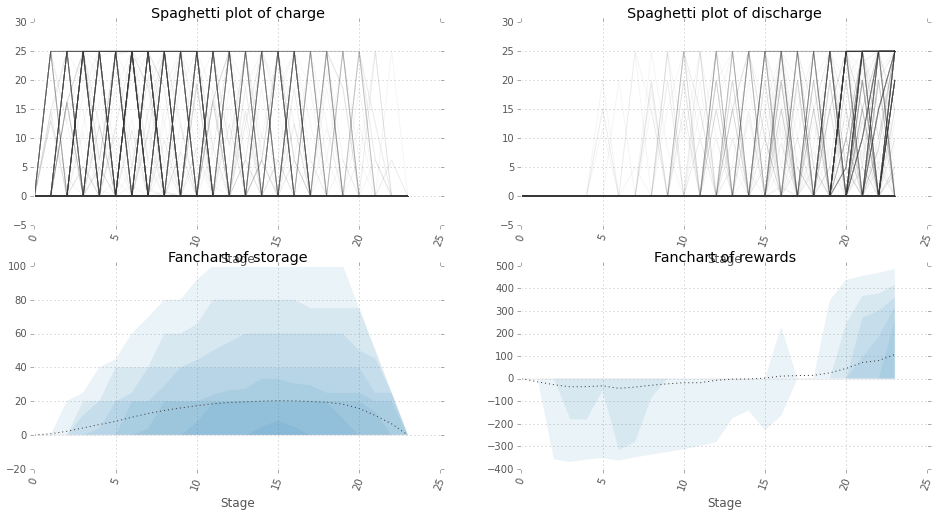

In [6]:
f, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(16,8))
sim.decision['charge'].spaghetti(ax1, alpha=.05)
sim.decision['discharge'].spaghetti(ax2, alpha=.05)
sim.decision['storage'].fanchart(ax3)
sim.rewards.fanchart(ax4)

/usr/local/lib/python2.7/site-packages/pandas/tools/plotting.py:2633: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  warnings.warn(msg, FutureWarning)


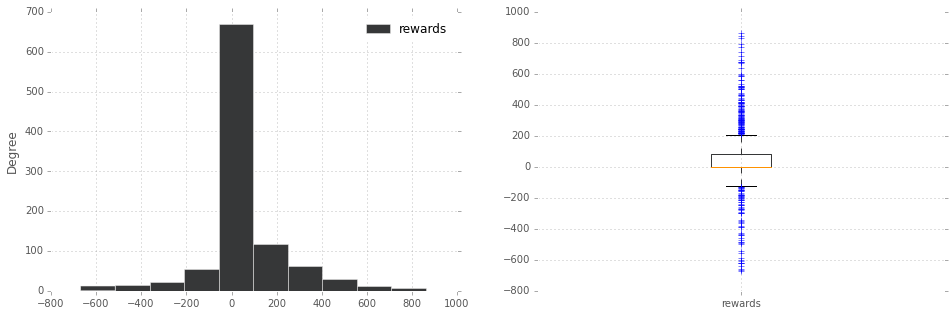

In [7]:
f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(16,5))
sim.rewards.groupby_series.sum().plot(kind='hist',ax=ax1)
sim.rewards.groupby_series.sum().boxplot(ax=ax2)
plt.show()

In [12]:
print sim.query('stage==12')[sim.decision['discharge']>1.e-4].state.price.min()

21.5913062258


In [11]:
print sim.query('stage==12')[sim.decision['charge']>1.e-4].state.price.max()

15.1573887518
